In [1]:
!pip install yfinance

In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.regression.quantile_regression import QuantReg
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define functions
# Define function to fetch data from Yahoo Finance and calculate returns
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']

def calculate_returns(prices):
    return prices.pct_change().dropna()

# Define function to calculate annual delta CoVaR
def calculate_annual_dcovar(bank_returns, market_returns):
    # Combine bank returns and market returns
    data = pd.concat([bank_returns, market_returns], axis=1).dropna()
    data.columns = ['bank_returns', 'market_returns']
    data['constant'] = 1
    
    # Group data by year
    grouped = data.groupby(data.index.year)
    
    annual_dcovar = {}
    for year, group in grouped:
        # Prepare the data for quantile regression
        Y = group['bank_returns']
        X = group[['constant', 'market_returns']]
        
        # Perform quantile regression at 1% and 50% quantiles
        model_1 = QuantReg(Y, X)
        model_50 = QuantReg(Y, X)
        
        results_1 = model_1.fit(q=0.01)
        results_50 = model_50.fit(q=0.5)
        
        # Calculate VaR at 1% and 50% quantiles
        var_1 = results_1.predict(X)
        var_50 = results_50.predict(X)
        
        # Calculate ACoVaR
        dcovar = var_1.mean() - var_50.mean()
        annual_dcovar[year] = dcovar
    
    return annual_dcovar

# Define function to classify systemic risk 
def classify_systemic_risk(dcovar_values):
    # Calculate the median and third quartile of ACoVaR values
    median_dcovar = np.median(dcovar_values)
    third_quartile_dcovar = np.percentile(dcovar_values, 75)
    
    # Classify banks based on their ACoVaR values
    classifications = []
    for dcovar in dcovar_values:
        if dcovar > third_quartile_dcovar:
            classifications.append("High")
        elif dcovar > median_dcovar:
            classifications.append("Moderate")
        else:
            classifications.append("Low")
    
    return classifications


In [4]:
# Set the date range for the analysis
start_date = "2004-01-01"
end_date = "2024-01-01"

# Fetch FTSE 100 data (state variable)
ftse100 = fetch_data("^FTSE", start_date, end_date)
ftse100_returns = calculate_returns(ftse100)

# List of UK banks (example tickers, please verify and update as needed)
uk_banks = ["HSBA.L", "BARC.L", "LLOY.L", "NWG.L", "STAN.L", 'AV.L','LGEN.L','PRU.L','SDR.L','III.L','HL.L',
            'INVP.L','SMT.L','ABDN.L','ICG.L','IGG.L','POLR.L', 'FCIT.L', 'QLT.L', 'ADM.L', 'MNKS.L', 'RCP.L',
            'EMG.L', 'DLG.L', 'CBG.L', 'RWS.L', 'VANQ.L', 'STB.L', 'HGT.L', 'CTY.L', 'JGGI.L',
            'RAT.L']


[*********************100%***********************]  1 of 1 completed


In [5]:
# Calculate annual ACoVaR for each bank
results = {}
for bank in uk_banks:
    bank_data = fetch_data(bank, start_date, end_date)
    bank_returns = calculate_returns(bank_data)
    annual_dcovar = calculate_annual_dcovar(bank_returns, ftse100_returns)
    results[bank] = annual_dcovar

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
# Create a DataFrame with results
df_results = pd.DataFrame(results)
df_results.index.name = 'Year'

In [7]:
df_results

,HSBA.L,BARC.L,LLOY.L,NWG.L,STAN.L,AV.L,LGEN.L,PRU.L,SDR.L,III.L,...,EMG.L,DLG.L,CBG.L,RWS.L,VANQ.L,STB.L,HGT.L,CTY.L,JGGI.L,RAT.L
Year,,,,,,,,,,,,,,,,,,,,,
2004,-0.017543,-0.030655,-0.020373,-0.022229,-0.021832,-0.023102,-0.023254,-0.048497,-0.028287,-0.025685,...,-0.051153,NaN,-7.887643e-09,-0.027129,-0.030734,NaN,-0.011402,-0.020230,-0.016557,-0.037582
2005,-0.011455,-0.019399,-0.015207,-0.017331,-0.022771,-0.018481,-0.020882,-0.021811,-0.021710,-0.018954,...,-0.028055,NaN,-8.854147e-09,-0.023931,-0.046012,NaN,-0.007920,-0.017528,-0.016070,-0.042607
2006,-0.012706,-0.016885,-0.015060,-0.013247,-0.024414,-0.023083,-0.024996,-0.033641,-0.031344,-0.017398,...,-0.031825,NaN,-1.771310e-02,-0.023475,-0.030610,NaN,-0.017013,-0.026568,-0.017607,-0.036052
2007,-0.012506,-0.037844,-0.020281,-0.032182,-0.029048,-0.033387,-0.033222,-0.022471,-0.027245,-0.036993,...,-0.034237,NaN,-2.392381e-02,-0.024182,-0.034859,NaN,-0.034953,-0.022753,-0.015242,-0.067179
2008,-0.064959,-0.090683,-0.133500,-0.159783,-0.106218,-0.073794,-0.068573,-0.124651,-0.077496,-0.099192,...,-0.163412,NaN,-7.897534e-09,-0.100819,-0.057294,NaN,-0.058570,-0.046348,-0.042963,-0.104681
2009,-0.068770,-0.141055,-0.266906,-0.148230,-0.057523,-0.138802,-0.092178,-0.069697,-0.052999,-0.085350,...,-0.060526,NaN,-2.525826e-02,-0.065939,-0.045112,NaN,-0.030138,-0.025227,-0.043339,-0.061387
2010,-0.018575,-0.037904,-0.113872,-0.067122,-0.040814,-0.031334,-0.040265,-0.068316,-0.035349,-0.029964,...,-0.044784,NaN,-2.445709e-02,-0.048404,-0.040394,NaN,-0.029195,-0.011925,-0.028858,-0.033848
2011,-0.028248,-0.045012,-0.056789,-0.075858,-0.028517,-0.028440,-0.027055,-0.027231,-0.029318,-0.035003,...,-0.060163,NaN,-2.457305e-02,-0.054070,-0.032863,-2.105959e-07,-0.038677,-0.012420,-0.033366,-0.041892
2012,-0.019129,-0.045148,-0.039245,-0.052176,-0.041246,-0.031093,-0.022175,-0.023415,-0.023937,-0.027799,...,-0.074360,-0.021684,-2.511798e-02,-0.049376,-0.027646,-4.786660e-02,-0.013867,-0.009636,-0.020660,-0.037044


In [8]:
df_results.isnull().any()

HSBA.L    False
BARC.L    False
LLOY.L    False
NWG.L     False
STAN.L    False
AV.L      False
LGEN.L    False
PRU.L     False
SDR.L     False
III.L     False
HL.L       True
INVP.L    False
SMT.L     False
ABDN.L     True
ICG.L     False
IGG.L      True
POLR.L     True
FCIT.L    False
QLT.L      True
ADM.L     False
MNKS.L    False
RCP.L     False
EMG.L     False
DLG.L      True
CBG.L     False
RWS.L     False
VANQ.L    False
STB.L      True
HGT.L     False
CTY.L     False
JGGI.L    False
RAT.L     False
dtype: bool

In [9]:
from sklearn.impute import KNNImputer
# Impute missing values using KNN
imputer = KNNImputer()
df_results[uk_banks] = imputer.fit_transform(df_results[uk_banks])

In [10]:
df_results.isnull().sum().sum()

0

In [11]:
# Classify systemic risk for each year
for year in df_results.index:
    dcovar_values = df_results.loc[year].values
    classifications = classify_systemic_risk(dcovar_values)
    for bank, classification in zip(uk_banks, classifications):
        df_results.loc[year, f'{bank}_Class'] = classification


In [12]:
print("Annual Delta CoVaR (ACoVaR) and Classifications for UK Banks (2007-2023):")
print(df_results.head())

Annual Delta CoVaR (ACoVaR) and Classifications for UK Banks (2007-2023):
        HSBA.L    BARC.L    LLOY.L     NWG.L    STAN.L      AV.L    LGEN.L  \
Year                                                                         
2004 -0.017543 -0.030655 -0.020373 -0.022229 -0.021832 -0.023102 -0.023254   
2005 -0.011455 -0.019399 -0.015207 -0.017331 -0.022771 -0.018481 -0.020882   
2006 -0.012706 -0.016885 -0.015060 -0.013247 -0.024414 -0.023083 -0.024996   
2007 -0.012506 -0.037844 -0.020281 -0.032182 -0.029048 -0.033387 -0.033222   
2008 -0.064959 -0.090683 -0.133500 -0.159783 -0.106218 -0.073794 -0.068573   

         PRU.L     SDR.L     III.L  ...  EMG.L_Class  DLG.L_Class  \
Year                                ...                             
2004 -0.048497 -0.028287 -0.025685  ...          Low     Moderate   
2005 -0.021811 -0.021710 -0.018954  ...          Low          Low   
2006 -0.033641 -0.031344 -0.017398  ...          Low     Moderate   
2007 -0.022471 -0.027245 -0.036993

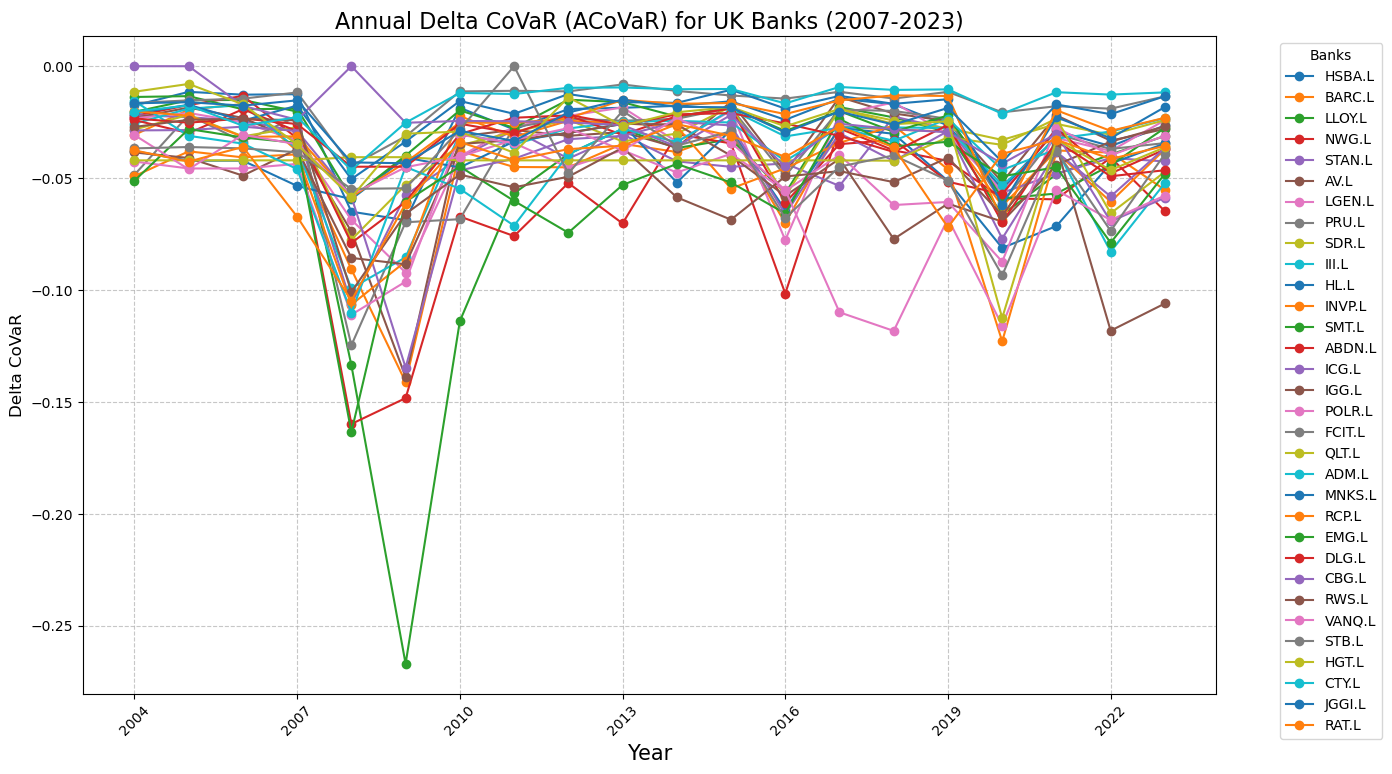

In [13]:
# Visualization
import matplotlib.pyplot as plt

# ACoVaR Values Plot
plt.figure(figsize=(14, 8))
for bank in uk_banks:
    plt.plot(df_results.index, df_results[bank], label=bank, marker='o')

plt.title('Annual Delta CoVaR (ACoVaR) for UK Banks (2007-2023)', fontsize=16)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Delta CoVaR', fontsize=12)
plt.legend(title='Banks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(df_results.index, rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


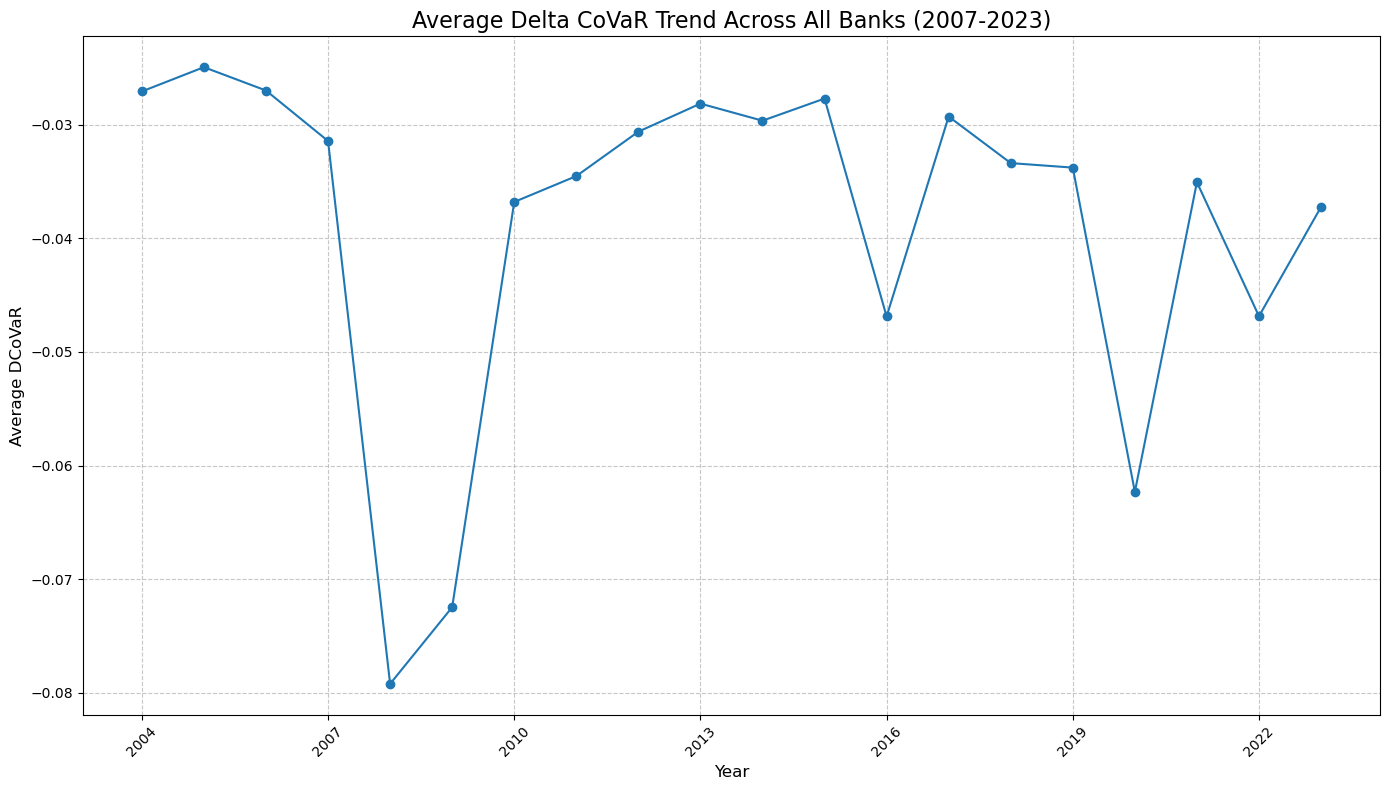

In [14]:
# Average dCoVaR Trend Across All Banks (2007-2023)
plt.figure(figsize=(14, 8))
df_results[uk_banks].mean(axis=1).plot(marker='o')
plt.title('Average Delta CoVaR Trend Across All Banks (2007-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average DCoVaR', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(df_results.index, rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


In [15]:
# Select only the 'Year' column and columns ending with '_Class'
classification_df = df_results.filter(regex='^Year$|_Class$')

# Rename the columns to remove the '_Class' suffix
classification_df.columns = [col.replace('_Class', '') for col in classification_df.columns]

In [16]:
classification_df

,HSBA.L,BARC.L,LLOY.L,NWG.L,STAN.L,AV.L,LGEN.L,PRU.L,SDR.L,III.L,...,EMG.L,DLG.L,CBG.L,RWS.L,VANQ.L,STB.L,HGT.L,CTY.L,JGGI.L,RAT.L
Year,,,,,,,,,,,,,,,,,,,,,
2004,High,Low,Moderate,Moderate,Moderate,Moderate,Moderate,Low,Low,Low,...,Low,Moderate,High,Low,Low,Low,High,Moderate,High,Low
2005,Moderate,Moderate,Moderate,Moderate,Low,Moderate,Low,Low,Low,Moderate,...,Low,Low,High,Low,Low,Low,Moderate,Moderate,Moderate,Low
2006,Moderate,Moderate,Moderate,Moderate,Low,Moderate,Low,Low,Low,Moderate,...,Low,Moderate,Moderate,Low,Low,Low,Moderate,Low,Moderate,Low
2007,Moderate,Low,Moderate,Low,Low,Low,Low,Moderate,Moderate,Low,...,Low,Moderate,Moderate,Moderate,Low,Low,Low,Moderate,Moderate,Low
2008,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,...,Low,High,High,Low,High,High,Low,High,High,Low
2009,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,...,Low,Low,High,Low,Low,Low,High,High,High,Low
2010,Moderate,Low,Low,Low,Low,Low,Low,Low,Low,Low,...,Low,Low,Moderate,Low,Low,Low,Low,High,Low,Low
2011,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,...,Low,Low,Low,Low,Low,High,Low,High,Low,Low
2012,Moderate,Low,Low,Low,Low,Low,Low,Low,Low,Low,...,Low,Moderate,Low,Low,Low,Low,Moderate,High,Moderate,Low


In [17]:
# If you want to merge this with your original bank data:
df = pd.read_csv('Dataset for dissertation.csv')

In [18]:
classification_df = classification_df.reset_index()

In [19]:
print(classification_df.columns)

Index(['Year', 'HSBA.L', 'BARC.L', 'LLOY.L', 'NWG.L', 'STAN.L', 'AV.L',
       'LGEN.L', 'PRU.L', 'SDR.L', 'III.L', 'HL.L', 'INVP.L', 'SMT.L',
       'ABDN.L', 'ICG.L', 'IGG.L', 'POLR.L', 'FCIT.L', 'QLT.L', 'ADM.L',
       'MNKS.L', 'RCP.L', 'EMG.L', 'DLG.L', 'CBG.L', 'RWS.L', 'VANQ.L',
       'STB.L', 'HGT.L', 'CTY.L', 'JGGI.L', 'RAT.L'],
      dtype='object')


In [54]:
# Melt the classification_df to long format
classification_long = pd.melt(classification_df, id_vars=['Year'], var_name='Ticker', value_name='Systemic Risk Emission')


In [56]:
# Ensure the 'Year' column in df is in the correct format
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Merge with the original bank data
merged_table = pd.merge(df, classification_long, on=['Year', 'Ticker'], how='left')

In [58]:
# Display the first few rows of the merged table
print(merged_table.head())

         Date        Institution  Ticker  Net Tangible Assets  \
0  31/12/2023  HSBC HOLDINGS PLC  HSBA.L          743946000.0   
1  31/12/2022  HSBC HOLDINGS PLC  HSBA.L          581408000.0   
2  31/12/2021  HSBC HOLDINGS PLC  HSBA.L          609711000.0   
3  31/12/2020  HSBC HOLDINGS PLC  HSBA.L          687978000.0   
4  31/12/2019  HSBC HOLDINGS PLC  HSBA.L          153661442.0   

  Shareholders Funds Return on shareholder funds      EBITDA  \
0          151185000                       15.76  23973000.0   
1          161987000                        8.94  12234000.0   
2          152761000                        9.14  12151000.0   
3          150037000                        4.28   6049000.0   
4          145212542                        6.93  17987640.0   

  Return on Total Assets Liquidity ratio  Shareholders liquidity ratio  \
0                      1             0.8                          0.25   
1                   0.59            0.74                          0.37   
2 

In [60]:
macro_data = pd.read_csv('Macro-economic variables.csv')

In [62]:
final_df = pd.merge(merged_table, macro_data, on='Year', how='left')

In [64]:
final_df.head()

,Date,Institution,Ticker,Net Tangible Assets,Shareholders Funds,Return on shareholder funds,EBITDA,Return on Total Assets,Liquidity ratio,Shareholders liquidity ratio,...,Year,Systemic Risk Emission,Total stock market volatility index,GBP/USD exchange rates,Effective exchange rate index,Interbank rate,UK Average house price,GDP growth rate,Inflation rate,Gold price percentage change
0,31/12/2023,HSBC HOLDINGS PLC,HSBA.L,743946000.0,151185000,15.76,23973000.0,1,0.8,0.25,...,2023,Low,26.2,1.149226,81.6873,4.960833,330429.0,0.1,7.3,0.1288
1,31/12/2022,HSBC HOLDINGS PLC,HSBA.L,581408000.0,161987000,8.94,12234000.0,0.59,0.74,0.37,...,2022,Low,20.2,1.173295,77.6475,2.000833,340432.0,4.3,9.1,0.0150
2,31/12/2021,HSBC HOLDINGS PLC,HSBA.L,609711000.0,152761000,9.14,12151000.0,0.64,0.81,0.32,...,2021,Low,27.3,1.162995,82.3781,0.090000,323595.0,8.7,2.6,-0.0258
3,31/12/2020,HSBC HOLDINGS PLC,HSBA.L,687978000.0,150037000,4.28,6049000.0,0.29,0.8,0.27,...,2020,Low,19.1,1.287900,78.9363,0.295000,303278.0,-10.4,0.9,0.2316
4,31/12/2019,HSBC HOLDINGS PLC,HSBA.L,153661442.0,145212542,6.93,17987640.0,0.49,1.07,6.14,...,2019,Moderate,16.4,1.294300,80.7424,0.807850,282174.0,1.6,1.8,0.1808


In [66]:
final_df.to_csv('Delta CoVaR data.csv')